# EXERCISE 3  - ML - Grundlagen und Algorithmen

Let's start with some imports. For this execise we again need numpy and matplotib but now also scipy

**Contributors**
- uloak (Markus Bilz)
- upomo (Julian Ziegler)
- uhluc (Finn Prox)

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
import scipy.optimize as opt
from typing import Tuple, Union, Optional


## 1.) Kernel Ridge Regression (6 Points)

In this task, we are going to get familiar with the kernel method and perform Kernel Ridge Regression using Gaussian kernels.

Work flow:
- Load and plot data
- Implement a function to get the Gaussian kernel vector
- Implement a function to get the Gaussian kernel matrix
- Implement a function to apply Kernel Ridge Regression 
- Select best model and see some result plots


### Load and plot data
First, let us load and plot our data. Note that in this example the test data is not corrupted by noise.


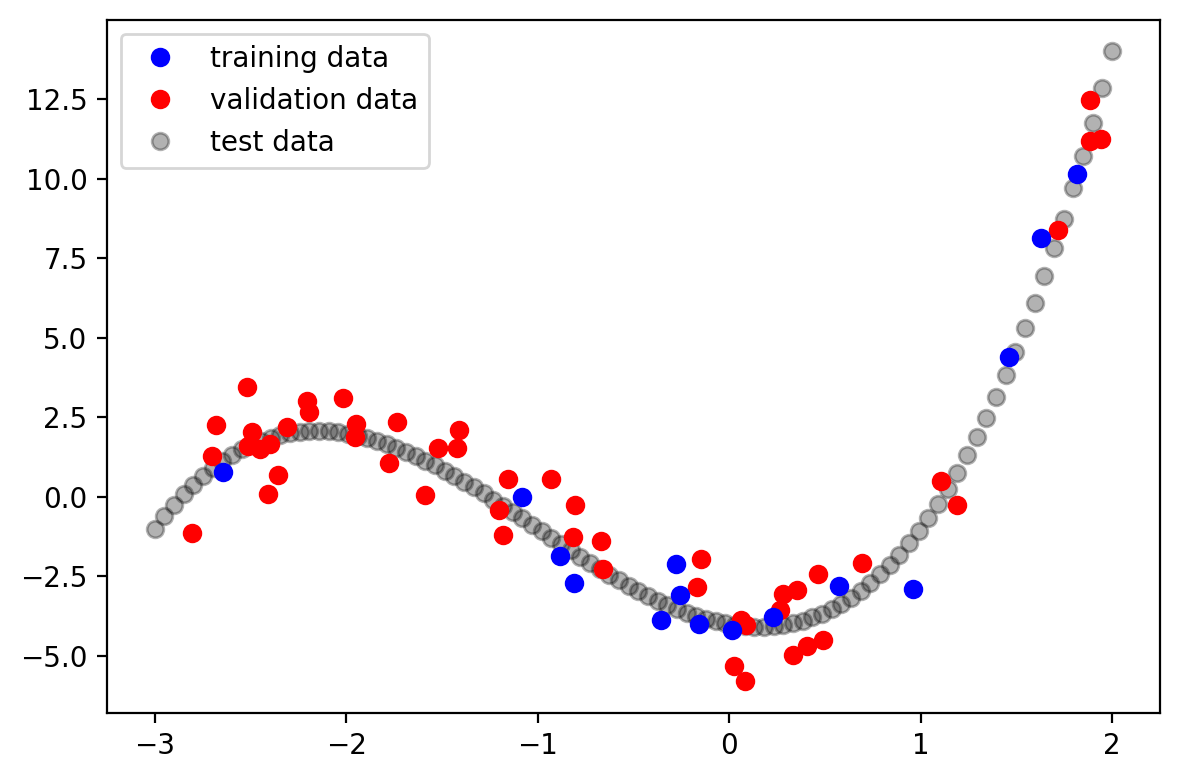

In [2]:


# Set random seed to obtain reproducible results
np.random.seed(0)  

# Load training, validation and test datasets
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')

x_valid = np.load('x_valid.npy')
y_valid = np.load('y_valid.npy')

x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

# Plot the data
plt.figure(dpi=200, tight_layout=True)
plt.plot(x_train, y_train, 'ob', label='training data', zorder=20)
plt.plot(x_valid, y_valid, 'or', label='validation data',zorder=10)
plt.plot(x_test, y_test, 'ok', label='test data', alpha=0.3, zorder=0)
plt.legend()
plt.show()

## Gaussian Kernels:
Since Gaussian kernels are the most commonly used kernels, we will concentrate on Gaussian kernels in this notebook. Remember the definition of a Gaussian kernel (lecture 5, slide 13):\
\begin{align*}
    k(\boldsymbol{x}, \boldsymbol{x^*}) = \exp\left(-\frac{||\boldsymbol{x}-\boldsymbol{x^*}||^2}{2\sigma^2}\right),
\end{align*}
where $\boldsymbol{x}, \boldsymbol{x^*}$ are two $d$-dimensional data points. $ \sigma $ is the bandwidth hyperparameter. Recall that any kernel $k(\boldsymbol{x}, \boldsymbol{x^*})$ returns a scalar which represents some kind of discrepancy measure between two data points.



### 1. Kernel Vector (3pts)
Now we are going to implement a function to compute the kernel vector $\boldsymbol k(\boldsymbol x^*)$ (lecture 5, slide 17). Recall the definition: given $N$ training points $\boldsymbol{x_i}, i=1,...,N$, and one additional query point $\boldsymbol{x^*}$, $\boldsymbol{k(x^*)}$ is defined as the $N$-dimensional vector whose $i$-th element is given by the kernel, evaluated at training point $\boldsymbol{x_i}$ and the query point, i.e. $k(\boldsymbol{x_i, x^*})$.

Please finish the function below!

Hints:
- As we typically have $M > 1$ query points in practice, we would like to compute the corresponding $M$ kernel vectors in one function call, cf. the comments. 
- The computations we have to perform are the same as in `gaussian_kernel()`. However, we are now operating on more than one input vectors at once.
- Avoid using loops! To this end, you may need to add additional dimensions to the input data and use broadcasting. Also, note that numpy operations such as `np.linalg.norm()` can operate on vector inputs and take an `axis`-argument!
- Make sure your code works also for data with dimension larger than 1. You are going to need this later.

In [3]:
def get_kernel_vec(X_t: np.ndarray, 
                   X_q: np.ndarray, 
                   sigma: float) -> np.ndarray:
    """
    :param X_t: N training inputs (shape: [N, d])
    :param X_q: M query inputs (shape: [M, d])
    :param sigma: bandwidth of the kernel (shape: scalar) 
    :return: M kernel vectors arranged as the columns of a matrix with shape [N, M]
    """
    ############## Your code starts here ##############
    norm_2 = np.sum(np.square(X_t[:,None,:]-X_q[None,:,]), axis=-1)
    kernel_vectors = np.exp((-0.5 / sigma**2) * norm_2)
    ############### Your code ends here ###############
    
    # assert the output shape being [N, M]
    assert list(kernel_vectors.shape) == [X_t.shape[0], X_q.shape[0]]
    return kernel_vectors

### Radial Basis Function (RBF) features 
Now we use `get_kernel_vec()` to compute the kernel vectors w.r.t. our training inputs, using the test inputs as the query points. This allows us to plot the RBF features: we observe that at each training data point a Gaussian bump (the Gaussian kernel) is centered and that the bandwith parameter specifies the width of each bump.

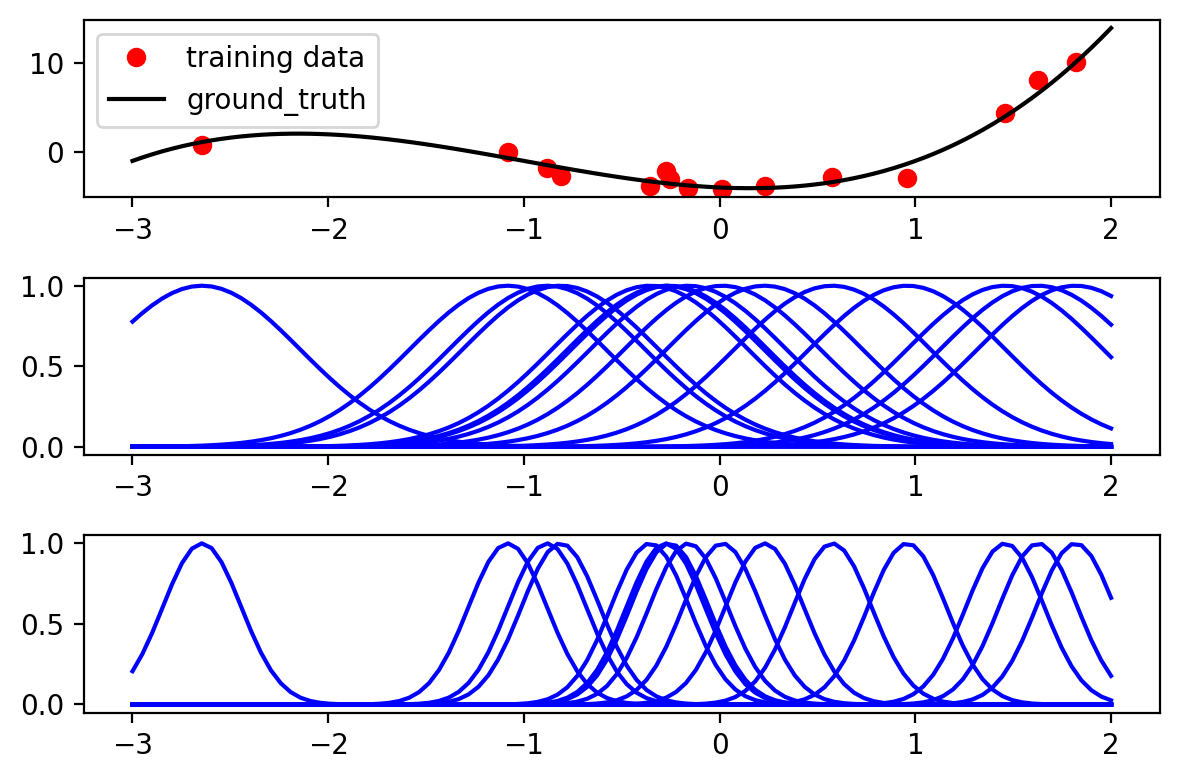

In [4]:
# Run this block to test your code 

# Compute the kernel vectors w.r.t. the training inputs, using the test inputs as query points 
kernel_vectors = get_kernel_vec(x_train, x_test, 0.5)
kernel_vectors2 = get_kernel_vec(x_train, x_test, 0.2)

# Prepare plot
plt.figure(dpi=200, tight_layout=True)

# Plot the data
plt.subplot(3,1,1)
plt.plot(x_train, y_train, 'ro')
plt.plot(x_test, y_test, 'k')
plt.legend(['training data', 'ground_truth'])

# Plot the kernel vectors
plt.subplot(3,1,2)
for kernel in kernel_vectors:
    plt.plot(x_test, kernel, 'b')

plt.subplot(3,1,3)
for kernel in kernel_vectors2:
    plt.plot(x_test, kernel, 'b')
plt.show()

## Kernel Ridge Regression with Gaussian Kernels

Let's go ahead and do regression using Gaussian kernels. Remember the regression equation (lecture 5, slide 25):

\begin{align*}
    f(\boldsymbol{x^*}) = \boldsymbol{k}(\boldsymbol{x^*})^T(\boldsymbol{K} + \lambda \boldsymbol{I})^{-1}\boldsymbol{y},
\end{align*}
where $ \boldsymbol{k}(\boldsymbol{x^*}) $ is the kernel vector, $ \boldsymbol{K}$ is the kernel matrix and $ \boldsymbol{y} $ are the target values from the training data. 

### 2. Kernel Matrix (1pt)
First, we have to compute the kernel matrix $\boldsymbol K$ (lecture 5, slide 17). Recall the definition: $[\boldsymbol K]_{ij} = k(\boldsymbol x_i, \boldsymbol x_j)$ with our training inputs $\boldsymbol{x_i}, i=1,...,N$.

Implement the function below (hint: re-use the `get_kernel_vec()` function)!

In [5]:
def get_kernel_mat(X: np.ndarray, sigma: float) -> np.ndarray:
    """
    :param X: N training inputs (shape [N, d])
    :sigma: bandwidth of the kernel (scalar)
    :return: the kernel matrix (shape [N, N])
    """
    ############## Your code starts here ##############
    kernel_mat = get_kernel_vec(X, X, sigma)
    ############### Your code ends here ###############
    # assert the output shape being [N, N]
    assert list(kernel_mat.shape) == [X.shape[0], X.shape[0]]
    return kernel_mat

### 3. Kernel Regression Prediction (2pts)
Now that we have finished the implementation of the kernel vector $\boldsymbol{k(x^*)}$ and the kernel matrix $\boldsymbol{K}$, we can compute the prediction $f(\boldsymbol{x^*})$ in the function in below. Here we choose a fixed ridge factor $ \lambda = 10^{-3}$. 

Hint: make sure you use numerically stable operations!


In [6]:
def predict(X_t: np.ndarray, y_t: np.ndarray,
            X_q: np.ndarray, sigma: float) -> np.ndarray:
    """
    :param X_t: N training inputs (shape [N, d])
    :param y_t: N training targets (shape [N, 1])
    :param X_q: M query inputs (shape [M, d])    
    :param sigma: bandwidth of the kernel (scalar)
    :return: predicted values at X_q (shape [M, 1])
    """
    k = get_kernel_vec(X_t, X_q, sigma) # shape [N, M]
    K = get_kernel_mat(X_t, sigma) # shape [N, N]
    ridge_factor = 1e-3    
    ############## Your code starts here ##############
    n = K.shape[0]
    prediction = k.T @ np.linalg.inv(K + ridge_factor * np.identity(n)) @ y_t 

    ############### Your code ends here ###############    
    return prediction

### Mean Squared Error
Once again, we will use the mean squared error to measure the training and test error:

In [7]:
def mse(y_target: np.ndarray, y_pred: np.ndarray) -> float:
    """
    :param y_target: true y values
    :param y_pred: predicted y values 
    :return: MSE
    """
    return np.sum((y_target-y_pred)**2)/y_pred.shape[0]

### Model selection
The Gaussian kernel method introduces a hyperparameter (the bandwidth $\sigma$). We have to determine its value via model selection. Here, we use the hold-out method, i.e., we try different $\sigma$ values and select the model which performs best on the validation dataset.

minimum validation error for sigma = 3.00


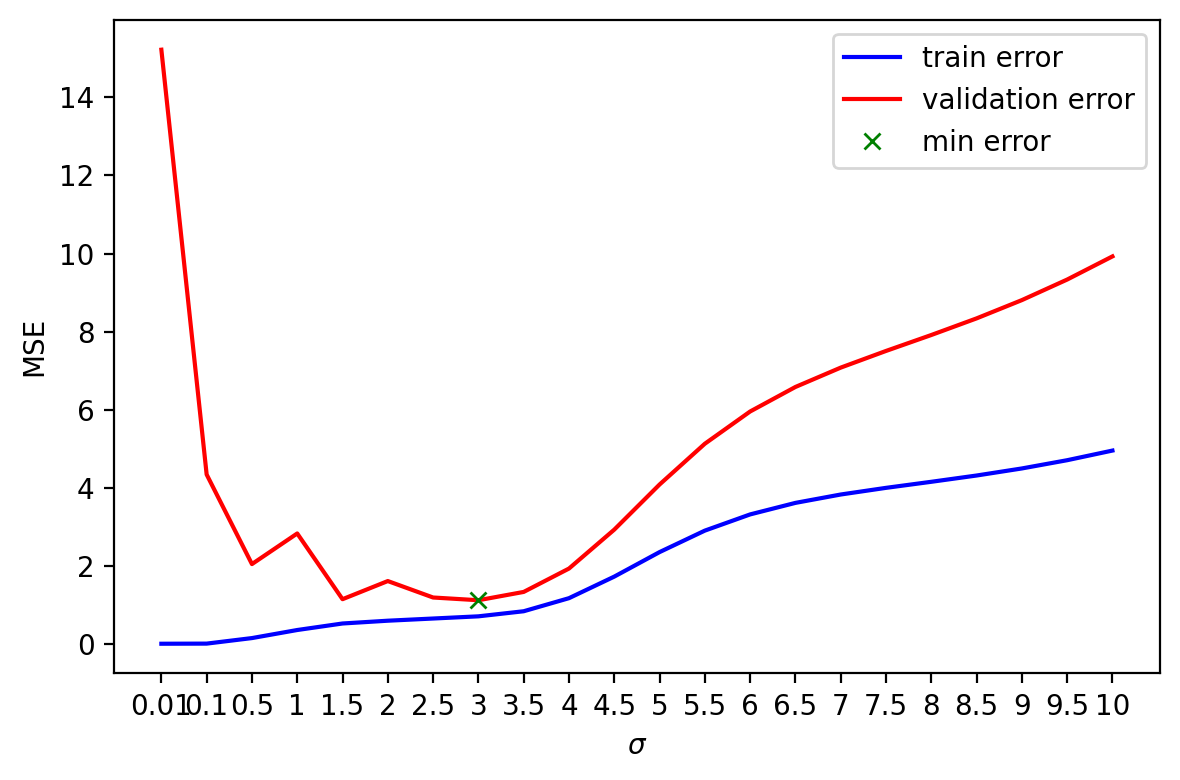

In [8]:
sigmas = [0.01, .1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10]

# compute train and validation errors for the different sigma values
train_errors = []
validate_errors = []
for sigma in sigmas:
    predict_train = predict(X_t=x_train, y_t=y_train,
                              X_q=x_train, sigma=sigma)
    predict_valid = predict(X_t=x_train, y_t=y_train,
                             X_q=x_valid, sigma=sigma)
    train_errors.append(mse(y_train, predict_train))
    validate_errors.append(mse(y_valid, predict_valid))
    
# determine best model
min_valid_error_index = validate_errors.index(min(validate_errors))
print(f'minimum validation error for sigma = {sigmas[min_valid_error_index]:.2f}')

# plot the errors
x_axis = [str(x) for x in sigmas]
error_plot = plt.figure(dpi=200, tight_layout=True)
plt.plot(x_axis, train_errors, 'b')
plt.plot(x_axis, validate_errors, 'r')
plt.plot(x_axis[min_valid_error_index], validate_errors[min_valid_error_index], 'gx')
plt.xlabel( "$\sigma$")
plt.ylabel( "MSE" )
plt.legend(['train error', 'validation error','min error'])

We again observe the typical behavior: we have clear overfitting for small $ \sigma $ values (high model complexity). For high $ \sigma $ values (low model complexity) we observe underfitting. The best performing model is marked with a green 'x', as the minimum validation error is achieved for $ \sigma = 3 $.

Let's look at predictions for different $ \sigma $ values.

sigma = 5.00
MSE train: 2.35
MSE valid: 4.08
MSE test : 2.91


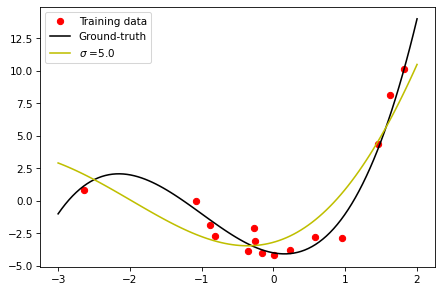

sigma = 3.00
MSE train: 0.70
MSE valid: 1.11
MSE test : 0.12


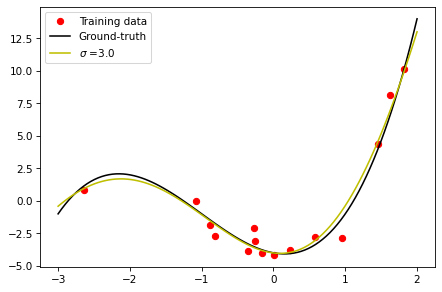

sigma = 1.00
MSE train: 0.35
MSE valid: 2.83
MSE test : 1.94


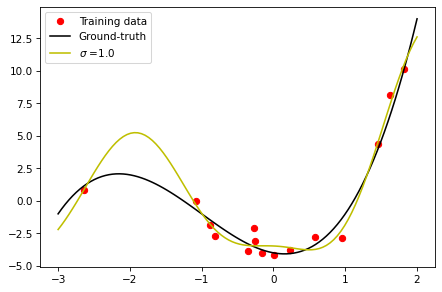

sigma = 0.10
MSE train: 0.00
MSE valid: 4.34
MSE test : 4.28


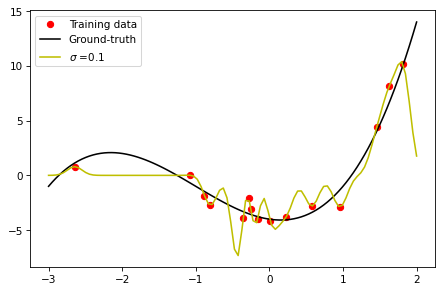

In [9]:
# plot predictions for various bandwith parameters
for sigma in [5.0,  3.0, 1.0 , 0.1]:    
    # compute predictions on train, test, and validation sets
    y_pred_train = predict(X_t=x_train, y_t=y_train, X_q=x_train, sigma=sigma)
    y_pred_valid = predict(X_t=x_train, y_t=y_train, X_q=x_valid, sigma=sigma)
    y_pred_test = predict(X_t=x_train, y_t=y_train, X_q=x_test, sigma=sigma)

    # print MSEs
    print(f'sigma = {sigma:.2f}')
    print(f'MSE train: {mse(y_train, y_pred_train):.2f}')
    print(f'MSE valid: {mse(y_valid, y_pred_valid):.2f}')
    print(f'MSE test : {mse(y_test, y_pred_test):.2f}')

    # plot predictions
    sigma_fig = plt.figure(dpi=75, tight_layout=True)
    plt.plot(x_train, y_train, 'ro')
    plt.plot(x_test, y_test, 'k')
    plt.plot(x_test, y_pred_test, 'y')
    plt.legend(['Training data', 'Ground-truth', '$\sigma$ =' + str(sigma)])
    plt.show()

We again observe that the model overfits for $ \sigma < 3.0 $ and underfits for $\sigma > 3.0$, with $\sigma = 3.0$ achieving the minimum validation error. 

Note that the model prediction reverts back to $0$ far away from training data (where "far away" has to be understood relative to the bandwidth $\sigma$). E.g., for $ \sigma = 0.1 $, the model prediction reverts back to $0$ in the input region [-2.5, -1.5] as all training points are "far away" w.r.t. the small bandwith value. 

## 2.) Constrained Optimization (6 Points)
Consider the following optimization problem:
\begin{align*}
    \underset{\boldsymbol{x}}{\textrm{ min }}& \boldsymbol{x}^T\boldsymbol{M}\boldsymbol{x} + \boldsymbol{x}^T \boldsymbol{h} \\
        \mathrm{s.t.} &\quad  \boldsymbol{x}^T \boldsymbol{b} \geq c,
\end{align*}
where $\boldsymbol{M}$ is a positive definite, symmetric matrix. Note that vectors are denoted by lower case bold symbols while matrices are denoted by upper case bold symbols.

Derive the optimal solution for $\boldsymbol{x}$. 

Hints:
- Make sure that your solution does not contain Lagrangian multiplier(s) (i.e., you have to solve for the dual).
- Make sure that you stick to the aforementioned convetions, i.e., denote vectors and matrices by bold symbols in lower case and upper case, respectively. Symbols which are not written in bold will be regarded as scalars.
- Do not forget to make use of the properties of $\boldsymbol{M}$ and look up vector-matrix calculus in the matrix cookbook if you don't remember the rules.

**Proof**<br>
1) Lagrangian

\begin{align*}
L \left( \boldsymbol{x} , \lambda \right) &= \boldsymbol{x}^T \boldsymbol{M} \boldsymbol{x} + \boldsymbol{x}^T \boldsymbol{h} -\lambda \left( \boldsymbol{x}^T \boldsymbol{b} - c \right)
\end{align*}

2) Find $\boldsymbol{x}^*$

\begin{align*}
\boldsymbol{x}^* &= \underset{\boldsymbol{x}}{ \textrm{argmin}}
L \left( \boldsymbol{x} , \lambda \right)\\
\frac{\partial L}{\partial \boldsymbol{x}} &= 2 \boldsymbol{M} \boldsymbol{x} +\boldsymbol{h} - \lambda \boldsymbol{b} = 0\\
\boldsymbol{x}^* &= \frac{1}{2} \boldsymbol{M}^{-1} \left( \lambda \boldsymbol{b} - \boldsymbol{h} \right)
\end{align*}

3) Dual function $g\left( \lambda \right)$

\begin{align*}
g \left( \lambda \right) &= L \left( \boldsymbol{x}^*, \lambda \right)
=  \boldsymbol{x}^{T} \boldsymbol{M} \boldsymbol{x} + \boldsymbol{x}^{T} \boldsymbol{h} - \lambda \boldsymbol{x}^{T} \boldsymbol{b} +\lambda c\\
&= \frac{1}{4} \left( \lambda \boldsymbol{b} - \boldsymbol{h} \right)^T\boldsymbol{M}^{-1} \left( \lambda \boldsymbol{b} - \boldsymbol{h} \right) +\frac{1}{2} \left( \lambda \boldsymbol{b} - \boldsymbol{h} \right)^T\boldsymbol{M}^{-1} \boldsymbol{h} - \frac{1}{2} \lambda \left( \lambda \boldsymbol{b} - \boldsymbol{h} \right)^T\boldsymbol{M}^{-1} \boldsymbol{b} + \lambda c\\
&= - \frac{\lambda^2}{4} \lambda{b}^T \boldsymbol{M}^{-1} \boldsymbol{b} +\frac{\lambda}{2} \lambda{b}^T \boldsymbol{M}^{-1} \boldsymbol{h} + \lambda c\\
s.t. \lambda \geq 0
\end{align*}

4) Find $\lambda^*$

\begin{align*}
\lambda^* &= \underset{\lambda}{\textrm {argmax}} g \left( \lambda \right)\\
\frac{\partial g}{\partial \lambda} &= - \frac{\lambda}{2} \boldsymbol{b}^T \boldsymbol{M}^{-1} \boldsymbol{b} +\frac{1}{2} \boldsymbol{b}^T \boldsymbol{M}^{-1} \boldsymbol{h} + c = 0\\
\lambda^* &= \frac{\boldsymbol{b}^T \boldsymbol{M}^{-1} \boldsymbol{h} + 2c}{\boldsymbol{b}^T \boldsymbol{M}^{-1} \boldsymbol{b}}
\end{align*}

5) optimal solution for $\boldsymbol{x}$
* if $\lambda^{*} \lt 0$ , then $\lambda^* = 0$

\begin{align*}
\boldsymbol{x}^{*} &= \frac{1}{2} \boldsymbol{M}^{-1} \left( \lambda \boldsymbol{b} - \boldsymbol{h} \right)\\
&= - \frac{1}{2} \boldsymbol{M}^{-1} \boldsymbol{h}
\end{align*}

* if $\lambda^* \geq 0$ , then $\lambda^* = \frac{\boldsymbol{b}^T \boldsymbol{M}^{-1} \boldsymbol{h} + 2c}{\boldsymbol{b}^T \boldsymbol{M}^{-1} \boldsymbol{b}}$

\begin{align*}
\boldsymbol{x}^* &= \frac{1}{2} \boldsymbol{M}^{-1} \left( \lambda \boldsymbol{b} - \boldsymbol{h} \right)\\
&= - \frac{1}{2} \boldsymbol{M}^{-1} \boldsymbol{h} + \lambda \frac{1}{2} \boldsymbol{M}^{-1} \boldsymbol{b}\\
&= - \frac{1}{2} \boldsymbol{M}^{-1} \boldsymbol{h} + \frac{1}{2}\frac{\boldsymbol{b}^T \boldsymbol{M}^{-1} \boldsymbol{h} + 2c}{\boldsymbol{b}^T \boldsymbol{M}^{-1} \boldsymbol{b}}\boldsymbol{M}^{-1} \boldsymbol{b} 
\end{align*}

## 3.) Kernelized Support Vector Machine (8 Points)
In this exercise, we will implement another SVM on the two moons dataset, this time using the kernel trick.

We will implement the kernelized dual optimization problem for training an SVM as stated in the slides of lecture 6. This problem is a quadratic optimization problem with both linear equality and inequality constraints. While such problems cannot be solved in closed form, efficient numerical solvers are well known and implemented in most programming languages. Here we will use Sequential Least-Squares Programming (SLSQP), provided by scipy. You can treat SLSQP as a black box here but also feel free to have a closer look.

We start by loading and visualizing the data.


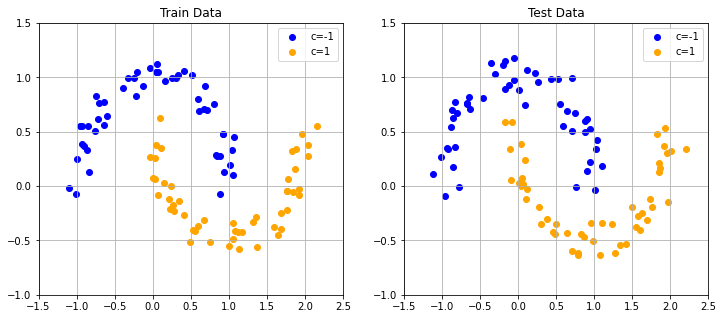

In [10]:
## load data
train_data = dict(np.load("two_moons.npz", allow_pickle=True))
train_samples = train_data["samples"]
train_labels = train_data["labels"]
# we need to change the labels for class 0 to -1 to account for the different labels used by an SVM 
train_labels[train_labels == 0] = -1 

test_data = dict(np.load("two_moons_test.npz", allow_pickle=True))
test_samples = test_data["samples"]
test_labels = test_data["labels"]
# we need to change the labels for class 0 to -1 to account for the different labels used by an SVM 
test_labels[test_labels == 0] = -1

## plot data
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.grid("on")
plt.xlim(-1.5, 2.5)
plt.ylim(-1, 1.5)
plt.title("Train Data")
plt.scatter(x=train_samples[train_labels == -1, 0], y=train_samples[train_labels == -1, 1], label="c=-1", c="blue")
plt.scatter(x=train_samples[train_labels == 1, 0], y=train_samples[train_labels == 1, 1], label="c=1", c="orange")

plt.legend()
plt.subplot(1, 2, 2)
plt.grid("on")
plt.xlim(-1.5, 2.5)
plt.ylim(-1, 1.5)
plt.title("Test Data")
plt.scatter(x=test_samples[test_labels == -1, 0], y=test_samples[test_labels == -1, 1], label="c=-1", c="blue")
plt.scatter(x=test_samples[test_labels == 1, 0], y=test_samples[test_labels == 1, 1], label="c=1", c="orange")

plt.legend()

## Exercise 3.1 - Implementation (5 Points)  

First, you are going to implement a kernelized SVM. We provide you with an interface to the SLSQP optimizer, but you still will need to implement the following functionalities below, cf. lecture 6 slide 52:
- You can reuse the `get_kernel_mat` and `get_kernel_vec` methods from the first exercise 
- Evaluate the objective and the constraints of the dual optimization problem for a given value of the dual parameter $\lambda$ during the optimization in `svm_dual`, `equality_constraint`, `inequality_constraint`, respectively. Using these functions, SLSQP can compute the optimal dual parameters $\boldsymbol \lambda^*$ by solving the dual optimization problem as shown in `fit_svm`.
- Compute the bias term $b$: part of `fit_svm`.
- Make predictions for new data points, given the training data, the optimal dual parameters $\boldsymbol \lambda^*$, and the bias term $b$: `predict_svm`,

**Hint:** Do not use any for-loops for your implementation. Always use vector/matrix operations!

In [11]:

def svm_dual(lam: np.ndarray, kernel_matrix: np.ndarray, labels: np.ndarray) -> float:
    """ Computes the dual function, i.e., the objective function of the kernelized SVM, which should be maximized.
    :param lam: current estimate of the Lagrangian multipliers / weights for each datapoint (shape: [N]) 
    :param kernel_matrix: kernel matrix between all datapoints in the train set (shape [N x N])
    :param labels: class labels corresponding to inputs from which kernel_matrix was computed (shape: [N])
    :return: current value of the dual function
    """
    ### TODO ######################

    # \max _{\lambda} \mathbf{1}^{T} \lambda-\frac{1}{2} \lambda^{T} \boldsymbol{H} \lambda
    
    n = lam.shape[0]
    H = labels[None, :] * labels[:, None] * kernel_matrix

    return np.ones(n).T @ lam - 0.5 * lam.T @ H @ lam
    ###############################


def equality_constraint(lam: np.ndarray, kernel_matrix: np.ndarray, labels: np.ndarray) -> np.ndarray:
    """ Computes the left-hand-side f(lambda) of the (set of) equality constraint(s) f(lambda) = 0
        of the SVM dual optimization problem.
    :param lam: current estimate of the lagrangian multipliers / weights for each datapoint (shape: [N]) 
    :param kernel_matrix: kernel matrix between all datapoints in the train set (shape [N x N])
    :param labels: class labels corresponding to to inputs from which kernel_matrix was computed (shape: [N])
    :return: left hand side of equality constraint 
    """
    ### TODO Hint: you might not need all of the function arguments ######################
    
    #\boldsymbol{y}^{T} \lambda=0
    
    return labels.T @ lam
    ###############################

def inequality_constraint(lam: np.ndarray, kernel_matrix: np.ndarray, labels: np.ndarray) -> np.ndarray:
    """ Computes the left-hand-side f(lambda) of the (set of) inequality constraint(s) f(lambda) >= 0
        of the SVM dual optimization problem.
    :param lam: current estimate of the lagrangian multipliers / weights for each datapoint (shape: [N]) 
    :param kernel_matrix: kernel matrix between all datapoints in the train set (shape [N x N])
    :param labels: class labels corresponding to to inputs from which kernel_matrix was computed (shape: [N])
    :return: left hand side of inequality constraint 
    """
    ### TODO Hint: you might not need all of the function arguments ######################
    
    #\boldsymbol{I} \lambda \leq \mathbf{0} 
    
    n = lam.shape[0]
    return np.eye(n) @ lam
    ###############################

def fit_svm(inputs: np.ndarray, labels: np.ndarray, sigma: float) -> Tuple[np.ndarray, float]:
    """
    fits an svm (with Gaussian kernel)
    :param inputs: inputs to fit the SVM to (shape: [N, data_dim])
    :param labels: class labels corresponding to inputs (shape: [N])
    :param sigma: bandwidth of gaussian kernel
    :return: optimal dual parameters lambda_star: weight for each datapoint in the dual formulation of SVM (shape [N]),
             bias term: constant offset 
    """
    ## compute kernel matrix
    kernel_matrix = get_kernel_mat(inputs, sigma) 

    ## solve optimization problem using numeric solver to get optimal weights for each data point 
    optimization_result = opt.minimize(
        # loss function (the scipy optimizer minimizes, we want to maximize,
        #                thus we need to flip the sign of the dual here)
        fun=lambda current_lam: - svm_dual(current_lam, kernel_matrix, labels),
        # initial guess = all zeros, one weight per data point 
        x0=np.zeros(inputs.shape[0]),
        # constraints                          
        constraints=[
            # first the inequality constaint
            {'type':'ineq',
             'fun':lambda current_lam: inequality_constraint(current_lam, kernel_matrix, labels)},
            # second the equality constraint
            {'type':'eq',
             'fun':lambda current_lam: equality_constraint(current_lam, kernel_matrix, labels)}
        ],
        # optimization method
        method='SLSQP', 
        # verbose 
        options={'disp': True})
    assert optimization_result.success, "Optimization Failed"
    lambda_star = optimization_result.x
       
    ## compute bias term
    ### TODO ######################
    bias = labels - lambda_star.T @ get_kernel_vec(inputs, inputs, sigma)
    ###############################
    return lambda_star, bias
    ###############################


def predict_svm(inputs_query: np.ndarray, inputs_train: np.ndarray, labels_train: np.ndarray,
                lambda_star: np.ndarray, bias: float, sigma: float) -> np.ndarray:
    """
    predict labels for query inputs given training data and weights
    :param inputs_query: query inputs (shape: [N_query, data_dim])
    :param inputs_train: inputs that where used to train svm (shape: [N_train, data_dim])
    :param inputs_train: labels corresponding to inputs that where used to train svm (shape: [N_train])
    :param lambda_star: optimal dual parameters computed by training procedure (shape: [N_train])
    :param bias: bias term computed by training procedure
    :param sigma: bandwidth of gaussian kernel
    :return: predicted labels at query inputs (shape: [N_query])
    """

    K_train = get_kernel_mat(inputs_train, sigma)
    b = np.mean(labels_train - np.sum(K_train * labels_train[:, None] * lambda_star, axis=0), axis=0)

    k_query = get_kernel_vec(inputs_train, inputs_query, sigma)
    predicted_labels = np.sum(k_query * labels_train[:, None] * lambda_star[:, None], axis=0) + b
    
    return predicted_labels

### Exercise 3.3 (3 Points)


We can now execute the code, train and visualize an SVM. For $\sigma = 0.3$ you should get a train accuracy of $1.0$ and a test accuracy of $> 0.97$. You will also get two plots. The first shows all data points together with the decision boundary, margins, and a contour plot of the SVM's predictions. The second one shows again the decision boundary and margins, now together with the support vectors (the lower the value $w_i$ is, the more transparent the corresponding point in the plot is, so you will not see most points and only the "important ones", i.e., the support vectors).   

Evaluate different values of sigma in the range of $0.01$ to $2.5$. What do you observe:
- How does the train accuracy change for different values? Why does it behave in this way?
- How does the test accuracy change for different values?
- How does the number of support vectors change for different values? What is the intuition behind this?
- For large values of $\sigma$ (roughly $\geq 2$) the optimizer will fail to solve the problem. This behavior is not a bug! Rather, it was to be expected. Why does this happen? How can we prevent it?

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.531189600113732
            Iterations: 26
            Function evaluations: 2632
            Gradient evaluations: 26
Train Accuracy:  1.0
Test Accuracy:  0.99


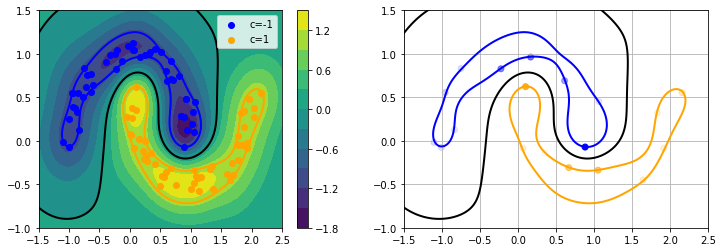

In [12]:
sigma = 0.3

## train an SVM
weights, bias = fit_svm(train_samples, train_labels, sigma)

## evaluate the SVM 
train_predictions = predict_svm(train_samples, train_samples, train_labels, weights, bias, sigma)
test_predictions = predict_svm(test_samples, train_samples, train_labels, weights, bias, sigma)

predicted_train_labels = np.ones(train_predictions.shape)
predicted_train_labels[train_predictions < 0] = -1
print("Train Accuracy: ", np.count_nonzero(predicted_train_labels == train_labels) / len(train_labels))

predicted_test_labels = np.ones(test_predictions.shape)
predicted_test_labels[test_predictions < 0] = -1
print("Test Accuracy: ", np.count_nonzero(predicted_test_labels == test_labels) / len(test_labels))

## plot train, contour, decision boundary and margins 
plt.figure(figsize=[12, 4])
plt.subplot(1, 2, 1)
plt_range = np.arange(-1.5, 2.5, 0.01)
plt_grid = np.stack(np.meshgrid(plt_range, plt_range), axis=-1)
flat_plt_grid = np.reshape(plt_grid, [-1, 2])
plt_grid_shape = plt_grid.shape[:2]

pred_grid = np.reshape(predict_svm(flat_plt_grid, train_samples, train_labels, weights, bias, sigma), plt_grid_shape)
plt.contour(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=[-1, 0, 1], colors=('blue', 'black', 'orange'),
             linestyles=('-',), linewidths=(2,))
plt.contourf(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=10)
plt.xlim(-1.5, 2.5)
plt.ylim(-1, 1.5)
plt.colorbar()

plt.scatter(x=train_samples[train_labels == -1, 0], y=train_samples[train_labels == -1, 1], label="c=-1", c="blue")
plt.scatter(x=train_samples[train_labels == 1, 0], y=train_samples[train_labels == 1, 1], label="c=1", c="orange")
plt.legend()

## plot margin, decision boundary and support vectors
plt.subplot(1, 2, 2)
plt.contour(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=[-1, 0, 1], colors=('blue', 'black', 'orange'),
             linestyles=('-',), linewidths=(2,))

## squeeze weights into interval [0, 1] and use as alpha channel for plotting
alphas_plt = np.clip(weights / np.max(weights), a_min=0.0, a_max=1.0)
for label, color in zip([-1, 1], ["blue", "orange"]):
    color_rgb = colors.to_rgb(color)
    samples = train_samples[train_labels == label]
    color_rgba = np.zeros((len(samples), 4))
    color_rgba[:, :3] = color_rgb
    color_rgba[:, 3] = alphas_plt[train_labels == label]
    plt.scatter(x=samples[:, 0], y=samples[:, 1], c=color_rgba)
plt.xlim(-1.5, 2.5)
plt.ylim(-1, 1.5)
plt.grid("on")
plt.show()

Optimization terminated successfully    (Exit mode 0)
            Current function value: -48.35231312295877
            Iterations: 6
            Function evaluations: 607
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -43.203020693816754
            Iterations: 20
            Function evaluations: 2020
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: -35.1061066876966
            Iterations: 32
            Function evaluations: 3232
            Gradient evaluations: 32
Optimization terminated successfully    (Exit mode 0)
            Current function value: -27.55110772298692
            Iterations: 25
            Function evaluations: 2527
            Gradient evaluations: 25
Optimization terminated successfully    (Exit mode 0)
            Current function value: -21.997665312521697
            Iterations: 36
            Functi

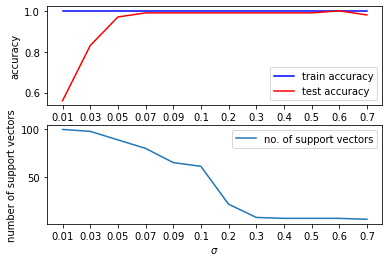

In [13]:
sigmas = np.array([0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

train_accuracy = []
test_accuracy = []
sv_num = []

for sigma in sigmas:
    weights, biass = fit_svm(train_samples, train_labels, sigma)
    train_predictions = predict_svm(train_samples, train_samples, train_labels, weights, bias, sigma)
    test_predictions = predict_svm(test_samples, train_samples, train_labels, weights, bias, sigma)

    
    alphas_plt = np.clip(weights / np.max(weights), a_min=0.0, a_max=1.0)
    alphas_plt[alphas_plt<0.3] = 0
    sv_num.append(np.count_nonzero(alphas_plt))
    
    predicted_train_labels = np.ones(train_predictions.shape)
    predicted_train_labels[train_predictions < 0] = -1
    train_accuracy.append(np.count_nonzero(predicted_train_labels == train_labels) / len(train_labels))
    
    predicted_test_labels = np.ones(test_predictions.shape)
    predicted_test_labels[test_predictions < 0] = -1
    test_accuracy.append(np.count_nonzero(predicted_test_labels == test_labels) / len(test_labels))
    
x_axis = [str(x) for x in sigmas]

plt.figure
plt.subplot(211)
plt.plot(x_axis,train_accuracy,'b')
plt.plot(x_axis,test_accuracy,'r')
plt.xlabel( "$\sigma$")
plt.ylabel( "accuracy" )
plt.legend(['train accuracy', 'test accuracy'])

plt.subplot(212)
plt.plot(x_axis,sv_num)
plt.xlabel( "$\sigma$")
plt.ylabel( "number of support vectors" )
plt.legend(["no. of support vectors"])

**Solution:**

Evaluate different values of sigma in the range of $0.01$ to $1.5$. What do you observe:

1. How does the train accuracy change for different values? Why does it behave in this way? &rightarrow; The train accuracy remains rather constant for differnt values of $\sigma$, but decreases for larger $\sigma$ (as seen above). The reason for this is, that the "two moons data set" can be easily split into its destinct classes even for wide bandwiths of the RBF kernel. Once the bandwidth is to large, the split into doesn't work properly any longer and therefore the train accuracy decreases.

2. How does the test accuracy change for different values? &rightarrow; The test accuracy is small for small $\sigma$. This is due to overfitting. When $\sigma$ becomes very large, the test accuracy could also decline, as a result of underfitting. In between ($\sigma \in \left[0.05, 0.6\right]$) there is a sweet spot, where the test accuracy is at max. 

3. How does the number of support vectors change for different values? What is the intuition behind this? &rightarrow; Generally speaking, the number of support vectors is decreasing with an increasing $\sigma$. The reason for this observation is, that for a larger $\sigma$ the decision boundary becomes more smooth and therefore less support vectors are required. For smaller $\sigma$'s the boundary becomes more precise (hence "sharp") and more support vectors are necessary. The phenomenon for small $\sigma$ is similar to overfitting and the phenomenon for large $\sigma$ is similar to underfitting.

4. For large values of $\sigma$ (roughly $\geq 2$) the optimizer will fail to solve the problem. This behavior is not a bug! Rather, it was to be expected. Why does this happen? How can we prevent it? &rightarrow; When using $\sigma \geq 1.18$ both train and test accuracies begin to drop until the optimizer doesn't finish within 100 iterations which is the default iteration maximum for the SLSQP method and is reached at $\sigma \approx 1.58$ for me, causing the optimizer to fail. Larger $\sigma$ generally require more time to converge. Therefore, if one were to increase the number of iterations we can prevent the optimization failing. However, even then we will observe only small train and test accuracies as the model uses too few support vectors to establish a meaningful decision boundary, leading it to underfit on the training data.